Import Libraries

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

Import the csv file

In [47]:
df = pd.read_csv("fitness_data.csv")

Data processing (Checking and replacing the missing values )

In [51]:
print(df.isnull().sum()) #printing out all the missing values

Age                              0
Gender                           0
Weight (kg)                      0
Height (m)                       0
Max_BPM                          0
Avg_BPM                          0
Resting_BPM                      0
Session_Duration (hours)         0
Calories_Burned                  0
Workout_Type                     0
Fat_Percentage                   0
Water_Intake (liters)            0
Workout_Frequency (days/week)    0
Experience_Level                 0
BMI                              0
dtype: int64


In [55]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)



Handling Max_BPM specifically remove the \t and convert them to numeric

In [ ]:
print("Missing values in 'Max_BPM':", df['Max_BPM'].isnull().sum())
# Remove tab characters
# df['Max_BPM'] = df['Max_BPM'].str.replace('\t', '', regex=False)
# Convert Max_BPM to string type
df['Max_BPM'] = df['Max_BPM'].astype(str)

# Then use the .str.replace() method to remove tabs
df['Max_BPM'] = df['Max_BPM'].str.replace('\t', '', regex=False)

# Check the cleaned column
print(df['Max_BPM'].head())




df['Max_BPM'] = pd.to_numeric(df['Max_BPM'], errors='coerce')
# Calculate the median (ignoring NaN values)
median_value = df['Max_BPM'].median()

# Fill missing values with the median
df['Max_BPM'].fillna(median_value, inplace=True)

Replacing missing values for all features.

In [ ]:
# Replacing missing gender with the most frequent gender
mode_gender = df['Gender'].mode()[0]
df['Gender'].fillna(mode_gender, inplace=True)
print(df['Gender'].isnull().sum()) #check whether if it is replaced

#Replacing age with medain
med_age = df['Age'].median()
df['Age'].fillna(med_age, inplace=True)

# Impute numerical features with median
for col in ['Weight (kg)', 'Height (m)', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned', 'Fat_Percentage', 'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'BMI']:
    df[col].fillna(df[col].median(), inplace=True)


# Impute categorical features with mode
for col in ['Workout_Type', 'Experience_Level']:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Recalculate BMI
df['BMI'] = df['Weight (kg)'] / (df['Height (m)'] ** 2)

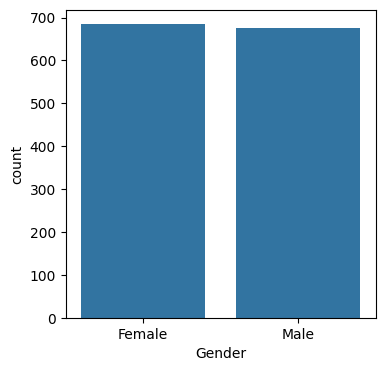

In [52]:
import seaborn as sns
plt.figure(figsize=(4,4))
sns.countplot(x= 'Gender',data=df)
plt.show()

In [49]:
from scipy import stats  
import numpy as np  

z_scores = np.abs(stats.zscore(df['Weight (kg)']))  
outliers = df[z_scores > 3]  
print(f"Outliers in Weight: {len(outliers)}")  

Outliers in Weight: 0


Use label encoder to convert male and female to numerical values.

In [53]:
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

Check correlation between features


                                    Age    Gender  Weight (kg)  Height (m)  \
Age                            1.000000  0.061940     0.001265   -0.042804   
Gender                         0.061940  1.000000     0.023583   -0.035412   
Weight (kg)                    0.001265  0.023583     1.000000   -0.060860   
Height (m)                    -0.042804 -0.035412    -0.060860    1.000000   
Max_BPM                       -0.000742  0.028561     0.008507    0.018028   
Avg_BPM                       -0.000543  0.045277     0.047271   -0.051654   
Resting_BPM                    0.021353  0.079566    -0.028779   -0.010109   
Session_Duration (hours)       0.012181  0.025752     0.006804    0.005541   
Calories_Burned               -0.010492 -0.063284    -0.022259    0.005184   
Fat_Percentage                -0.040513 -0.004503     0.008993   -0.041918   
Water_Intake (liters)         -0.055580  0.011137    -0.014335   -0.037707   
Workout_Frequency (days/week)  0.039745  0.048368    -0.037074  

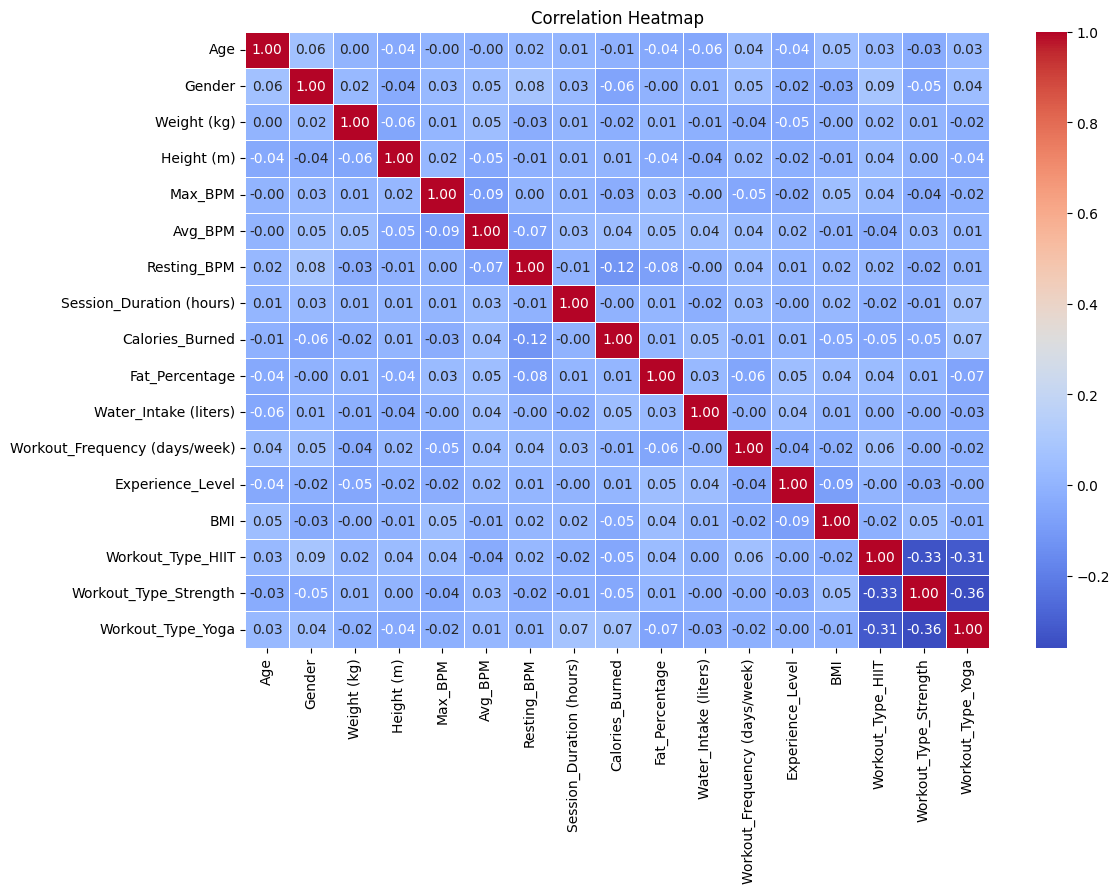

In [57]:
import seaborn as sns

# One-hot encode the 'Workout_Type' column
df = pd.get_dummies(df, columns=['Workout_Type'], drop_first=True)

# Now you can compute the correlation matrix
correlation_matrix = df.corr()
print(correlation_matrix)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Standardize numerical variables

In [58]:
from sklearn.preprocessing import StandardScaler

# Define numerical features (excluding target variable)
numerical_features = [
    "Age", "Weight (kg)", "Height (m)", "Max_BPM", "Avg_BPM", "Resting_BPM",
    "Session_Duration (hours)", "Fat_Percentage", "Water_Intake (liters)",
    "Workout_Frequency (days/week)", "BMI"
]

# Standardize numerical features
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [59]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df["Calories_Burned"] = scaler.fit_transform(df[["Calories_Burned"]])


Splitting Data for training

In [60]:
from sklearn.model_selection import train_test_split

# Features (X) and target variable (y)
X = df.drop(columns=["Calories_Burned"])  # Drop the target column
y = df["Calories_Burned"]  # Target variable

# Split into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(1087, 16) (272, 16) (1087,) (272,)


Random Forest

In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2}")


Mean Absolute Error: 0.7923434332399983
R-squared Score: -0.011692449084540257


XGBoost

In [62]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Train XGBoost model
model = XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2}")


Mean Absolute Error: 0.8397382796195437
R-squared Score: -0.10049760510673167


# DNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
correlation_matrix = df.corr()

# Extract correlation with Calories_Burned
calories_correlation = correlation_matrix["Calories_Burned"].sort_values(ascending=False)

# Display correlations
print(calories_correlation)

# Heatmap Visualization
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()
